In [15]:
import warnings
import matplotlib
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
from tasks.R2R.env import R2RBatch
from utils import Tokenizer, read_vocab
from vocab import TRAINVAL_VOCAB, TRAIN_VOCAB
vocab = read_vocab(TRAIN_VOCAB)
tok = Tokenizer(vocab)
env = R2RBatch(['none'], batch_size=64, splits=['train','val_seen','val_unseen'],tokenizer=tok)

Loading navigation graphs for 72 scans
R2RBatch loaded with 17409 instructions, using splits: train,val_seen,val_unseen


In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns; sns.set_style("white")
import numpy as np
import os
import json
from tasks.R2R.eval import Evaluation
e = Evaluation(['train','test','val_seen','val_unseen'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def grab_traj(outfile):
    with open(outfile) as f:
        inspection, eval_res = e.inspect_results(json.load(f))
    print(inspection.keys())

    N = len(inspection['instr_id'])
    traj = {}
    for i in range(N):
        new_item = {}
        for k in inspection.keys():
            new_item[k] = inspection[k][i]
        traj[inspection['instr_id'][i]] = new_item
    return traj

In [16]:
########### INPUT THE DESIRED TRAJECTORIES HERE
#outfolder = ''
#print(os.listdir(outfolder))
outfile1 = 'tasks/R2R/experiments/GreedyDecoding.len10.K1.early_stop/resultsfollower_cg_pm_sample_imagenet_mean_pooled_1heads_val_unseen.json'
outfile2 = 'tasks/R2R/experiments/T.sum_logit/results/follower_cg_pm_sample_imagenet_mean_pooled_1heads_val_unseen.json'

traj1 = grab_traj(outfile1)
traj2 = grab_traj(outfile2)

Inspected 2349
Skipped 0
dict_keys(['instr_id', 'path', 'ontrack', '%ontrack', 'good_segments', 'good/rollout', 'good/gt', 'success'])
Inspected 2349
Skipped 0
dict_keys(['instr_id', 'path', 'ontrack', '%ontrack', 'good_segments', 'good/rollout', 'good/gt', 'success'])


In [45]:
s1 = set([t['instr_id'] for t in traj1.values() if t['success']])
s2 = set([t['instr_id'] for t in traj2.values() if t['success']])
print(sorted(list(s2 - s1)))

import random
sampled = random.choice(list(s2 - s1))
print(sampled)
print(e.instructions[sampled])

['1027_2', '1030_0', '1041_2', '1192_2', '1194_0', '1194_1', '1269_0', '1269_2', '1275_0', '1275_1', '1282_0', '1282_2', '1316_2', '1404_1', '1404_2', '1420_1', '1431_0', '1431_1', '1505_1', '1549_1', '1549_2', '1567_1', '1567_2', '1597_0', '1598_2', '15_1', '161_0', '162_1', '1654_0', '1690_2', '1716_0', '1720_1', '1759_1', '1879_0', '1879_1', '1879_2', '1888_2', '1911_2', '1958_1', '1993_0', '1993_1', '1993_2', '2141_0', '214_0', '214_1', '2204_0', '2250_0', '2250_1', '2288_2', '2291_2', '2371_0', '2371_2', '2472_0', '2472_1', '2599_0', '260_0', '260_2', '2617_2', '2658_1', '2665_0', '2668_0', '2693_0', '2749_0', '2751_1', '2751_2', '2788_1', '2803_2', '2804_0', '2933_0', '2933_2', '3012_0', '3090_1', '3121_0', '312_0', '3155_0', '3155_1', '3234_0', '3234_2', '3356_0', '3356_1', '3356_2', '3406_2', '3419_2', '3433_0', '3530_0', '3531_1', '3552_0', '3552_2', '3627_0', '3627_1', '3627_2', '3651_2', '3659_1', '3669_0', '3785_0', '3785_2', '3822_0', '384_1', '384_2', '3896_1', '3908_1', 

In [26]:
import networkx as nx

def plot_each(v):
    instr_id = v['instr_id']
    gt = e.gt[int(instr_id.split('_')[0])]
    graph = e.graphs[gt['scan']]
    
    node_pos = nx.get_node_attributes(graph,'position')
    for k,vv in node_pos.items():
        node_pos[k] = vv[:-1]
    #nx.draw(graph, pos=node_pos)
    #plt.axis('off')
    
    rel_pos = [node_pos[vp] for vp in v['path']]
    rel_x = [r[0] for r in rel_pos]
    rel_y = [r[1] for r in rel_pos]
    xlim = [min(rel_x)-3, max(rel_x)+3]
    ylim = [min(rel_y)-3, max(rel_y)+3]
    
    _G = nx.Graph()
    _nodes = set()
    last_vp = None
    for vp in v['path']:
        if vp not in _nodes:
            _G.add_node(vp, pos=node_pos[vp])
            _nodes.add(vp)
        if last_vp:
            _G.add_edge(last_vp, vp)
        last_vp = vp
        
        fig, ax = plt.subplots()
        nx.draw_networkx_nodes(_G, pos=node_pos, ax=ax, node_size=100, nodelist=[vp], node_color='r')
        nx.draw_networkx_nodes(_G, pos=node_pos, ax=ax, node_size=100, nodelist=_nodes - set([vp]), node_color='b')
        nx.draw_networkx_edges(_G, pos=node_pos, ax=ax, alpha=1, width=3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plt.axis('off')
        plt.show()

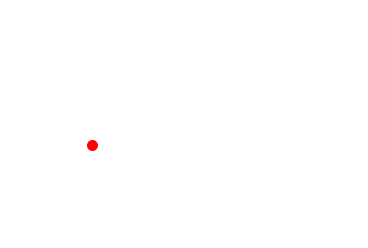

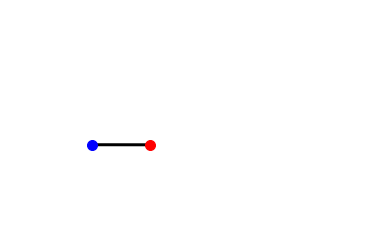

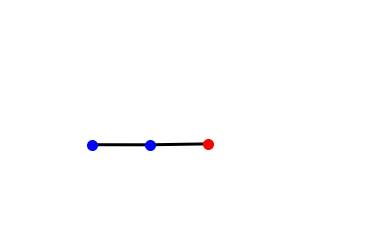

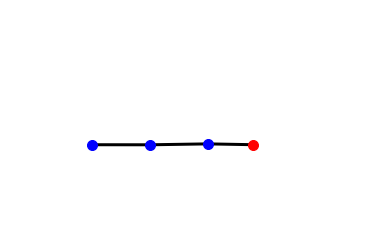

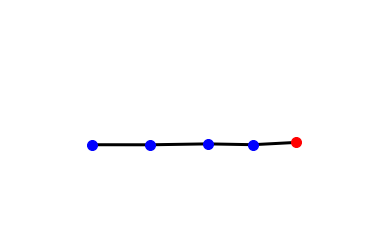

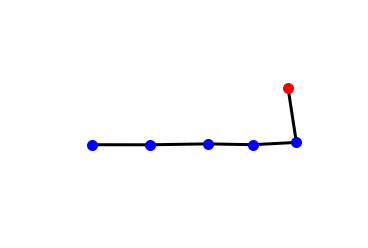

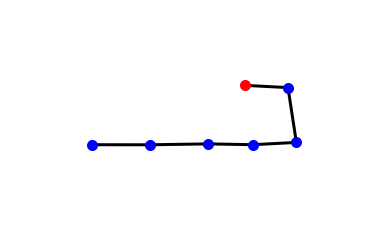

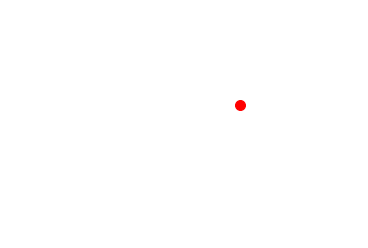

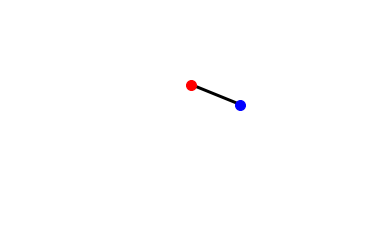

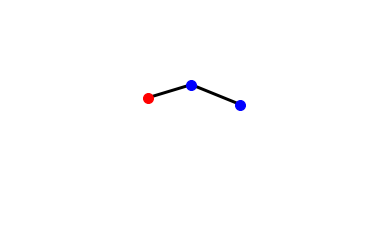

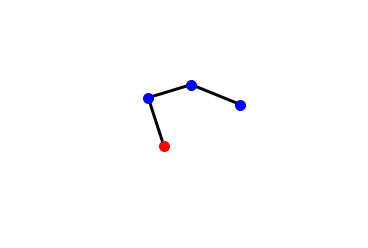

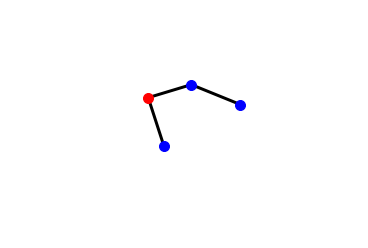

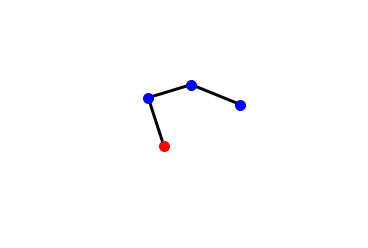

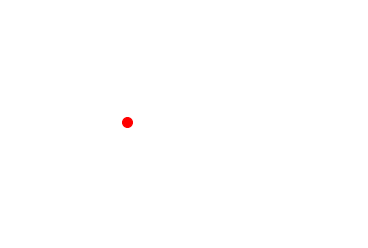

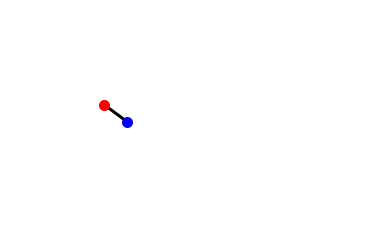

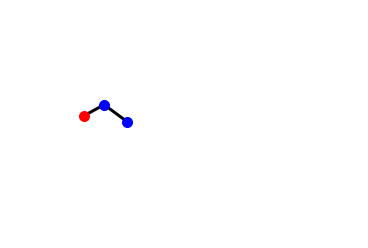

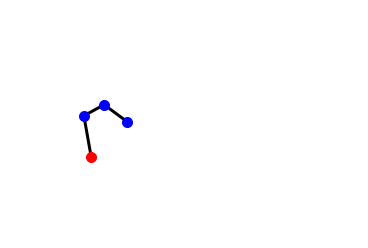

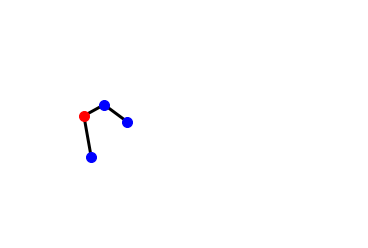

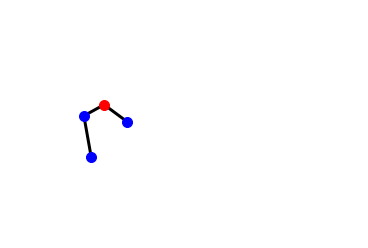

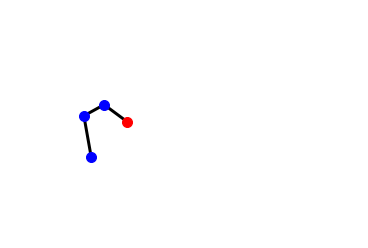

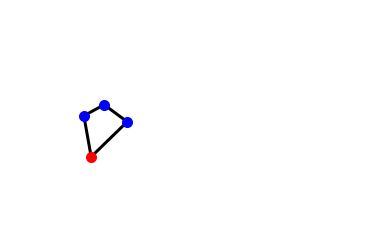

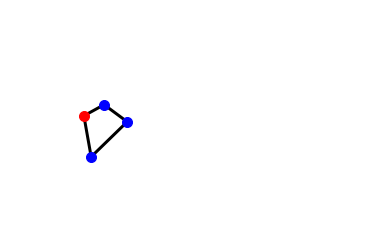

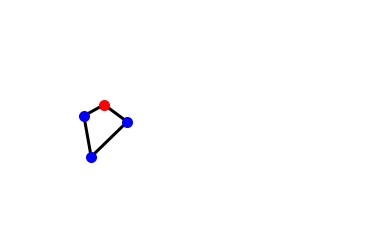

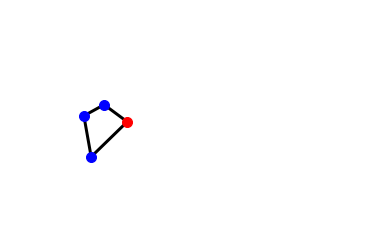

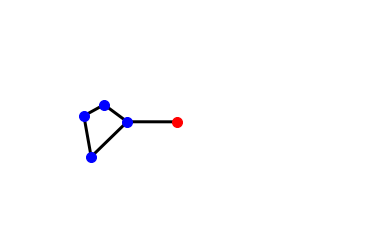

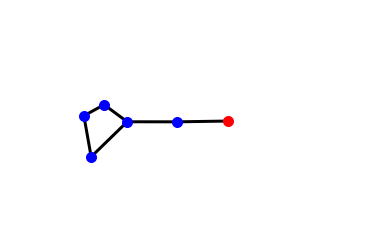

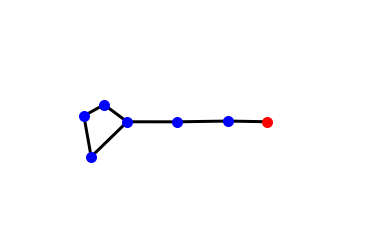

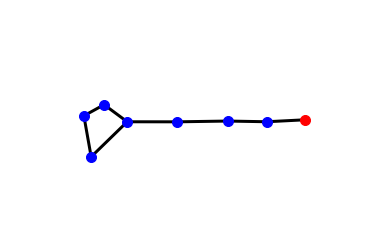

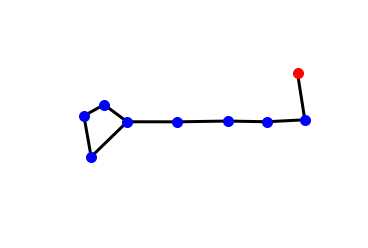

In [34]:
def get_ground_truth(instr_id):
    gt = e.gt[int(instr_id.split('_')[0])]
    item = {'instr_id': sampled, 'path': gt['path']}
    return item
plot_each(get_ground_truth(sampled))
plot_each(traj1[sampled])
plot_each(traj2[sampled])

In [38]:
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def plot_gif(v):
    instr_id = v['instr_id']
    gt = e.gt[int(instr_id.split('_')[0])]
    graph = e.graphs[gt['scan']]
    
    node_pos = nx.get_node_attributes(graph,'position')
    for k,vv in node_pos.items():
        node_pos[k] = vv[:-1]
    
    rel_pos = [node_pos[vp] for vp in v['path']]
    rel_x = [r[0] for r in rel_pos]
    rel_y = [r[1] for r in rel_pos]
    xlim = [min(rel_x)-3, max(rel_x)+3]
    ylim = [min(rel_y)-3, max(rel_y)+3]
    
    _G = nx.Graph()
    _nodes = set()
    fig, ax = plt.subplots()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.axis('off')
    
    def init():
        pass
    
    def animate(i):
        vp = v['path'][i]
        if vp not in _nodes:
            _G.add_node(vp, pos=node_pos[vp])
            _nodes.add(vp)
        if i > 0:
            _G.add_edge(v['path'][i-1], vp)
        
        nx.draw_networkx_nodes(_G, pos=node_pos, ax=ax, node_size=100, nodelist=[vp], node_color='r')
        nx.draw_networkx_nodes(_G, pos=node_pos, ax=ax, node_size=100, nodelist=_nodes - set([vp]), node_color='b')
        nx.draw_networkx_edges(_G, pos=node_pos, ax=ax, alpha=1, width=3)
    
    t = len(v['path'])
    return matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=t, repeat=False)

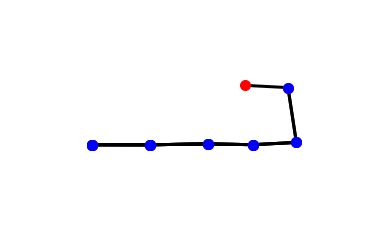

In [39]:
plot_gif(get_ground_truth(sampled))

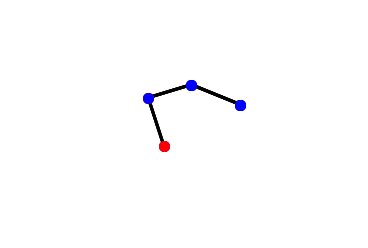

In [40]:
plot_gif(traj1[sampled])

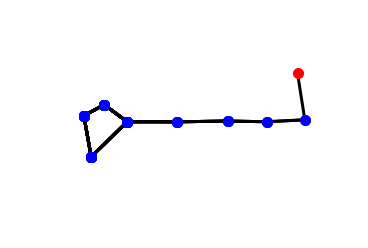

In [41]:
plot_gif(traj2[sampled])